In [1]:
# Install required packages 
!pip install pysptools
!pip install multiprocess
!pip install cvxopt
!pip install --upgrade seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 25.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pysptools: filename=pysptools-0.15.0-py3-none-any.whl size=8133732 sha256=50ef0670b9bf4c5e7e42d3fad271b701ba36c2f2878f89910430113f24f10803
  Stored in directory: /home/jovyan/.cache/pip/wheels/ea/08/3b/c045ea3722a5fef1f8698f060a17b59140235fef580fe4f1b5
Successfully built pysptools
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/35/a8/36d8d7b3e46b377800d8dec47891cdf05842d1a2366909ae4a0c89fbc5e6/multiprocess-0.70.15-py310-none-any.whl.metadata
  Obtaining dependency information for dill>=0.3.7 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 29.4 MB/s eta 0:

In [2]:

"""
Implementation of Linear Spectral Unmixing Analysis (LSMA) for fractional roof material type

"""

import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy.plot as ep
import pysptools.util as sp_utils
import pysptools.noise as noise
import pysptools.abundance_maps as amap
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocess as mp
import cvxopt
import random
from osgeo import gdal
from osgeo import osr
from osgeo import gdal_array
from functools import partial
from functools import reduce

print(os.getcwd())

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Completed ...")

/home/jovyan
Completed ...


In [3]:

"""
Supporting functions for the OPP rooftop materials mapping project

List of functions:

'array_to_tif': convert a numpy array to a GeoTIFF with spatial dimensions of a reference image
'pixel_to_xy': convert pixel to lat/long coordinates
'mnf_transform': generate N components of a Minimum Noise Fraction (MNF) transformation on an image array
'ravel_and_filter': converts a numpy array (m,n,p) to ((m*n), p)
'lsma': simple Linear Spectral Mixture Analysis (LSMA)
'mesma': extention of LSMA to handle multiple endmembers
'partition': split an array into chunks for multiprocessing work

"""


#############
# Functions #
#############


def array_to_tif(arr, ref, out_path, clip=False, shp=None):
    """
    Generate a xarray DataArray with spatial information
    Match dimensions to a reference image
    """
    # Transpose the new array before exporting
    in_arr = arr.transpose(2, 1, 0)
    print(in_arr.shape)
    # Assign the correct coordinates for the transposed 'y' dimension
    band_coords = range(in_arr.shape[0])
    y_coords = ref.y.values
    x_coords = ref.x.values
    # Store the new array and export
    out_arr = xr.DataArray(
        in_arr,
        dims=("band", "y", "x"),
        coords={
            "band": band_coords,
            "y": y_coords,
            "x": x_coords,
        }
    )
    # Export the new DataArray as a new GeoTIFF file
    out_arr.rio.set_crs(ref.rio.crs)  # Set the CRS
    out_arr.rio.write_transform(ref.rio.transform())  # Set the GeoTransform
    if clip is True and shp is not None:
        print("Clipping raster array ...")
        out_arr = out_arr.rio.clip(shp.geometry)
    elif clip is True and shp is None:
        print("Provide a shapefile for clipping geometry ...")
    out_arr.rio.to_raster(out_path, compress='zstd', zstd_level=1,
                          dtype='float32', driver='GTiff')  # export to GeoTIFF

    print(f"Successfully exported array to '{out_path}'")

    return out_arr


# Function to sample raster values to points for multi-band image
def img_vals_at_pts(img, points):
    # Extract x and y coordinates from the points
    x_coords = points["geometry"].x.values.astype(int)
    y_coords = points["geometry"].y.values.astype(int)
    # Ensure coordinates are within the image bounds
    x_coords = np.clip(x_coords, 0, img.shape[2] - 1)
    y_coords = np.clip(y_coords, 0, img.shape[1] - 1)
    # Sample the values at the specified points
    sampled_values = img[:, y_coords, x_coords]
    return np.asarray(sampled_values)



def mnf_transform(data_arr,n_components=5,nodata=-9999):
    """
        Applies the MNF rotation to a raster array; returns in HSI form
        (m x n x p). Arguments:
            rast    A NumPy raster array
            nodata  The NoData value
    """
    arr = data_arr.copy().transpose()
    arr[arr == nodata] = 0  # Remap any lingering NoData values
    # Apply the Minimum Noise Fraction (MNF) rotation
    mnf = noise.MNF()
    mnf_arr = mnf.apply(arr)
    if n_components is not None:
        return mnf_arr  # return the entire array
    else:
        print(f"Returning {n_components} components ...")
        return mnf_arr.get_components(n_components)  # return n components


def ravel_and_filter(arr, cleanup=True, nodata=-9999):
    """
    Reshapes a (p, m, n) array to ((m*n), p) where p is the number of
    dimensions and, optionally, filters out the NoData values. Assumes the
    first axis is the shortest. Arguments:
        arr      A NumPy array with shape (p, m, n)
        cleanup  True to filter out NoData values (otherwise, only ravels)
        nodata   The NoData value; only used in filtering
    """
    shp = arr.shape
    # If the array has already been raveled
    if len(shp) == 1 and cleanup:
        return arr[arr != nodata]
    # If a "single-band" image
    if len(shp) == 2:
        arr = arr.reshape(1, shp[-2]*shp[-1]).swapaxes(0, 1)
        if cleanup:
            return arr[arr != nodata]
    # For multi-band images
    else:
        arr = arr.reshape(shp[0], shp[1]*shp[2]).swapaxes(0, 1)
        if cleanup:
            return arr[arr[:,0] != nodata]
    return arr


# Implementation of the Fully Constrained Least Squares (FCLS)
def lsma_(cases, members):
    # For regular LSMA with single endmember spectra
    am = amap.FCLS()
    # c is number of pixels, k is number of bands
    cc, kk = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    print(f"c: {cc}; k: {kk}")
    return am.map(cases.reshape((1, cc, kk)), members, normalize=False)


# Adjustment to handle multiple endmembers
def mesma_(array_pairs):
    am = amap.FCLS()
    # For multiple endmember spectra, in chunks
    cases, endmembers = array_pairs
    # c is number of pixels, k is number of bands
    c, k = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    return [
        am.map(
            cases[i,...].reshape((1, 1, k)), 
            endmembers[i,...],
            normalize = False) for i in range(0, c)
    ]
    

def partition(array, processes, axis=0):
    """
    Creates index ranges for partitioning an array to work on over multiple
    processes. Arguments:
        array           The 2-dimensional array to partition
        processes       The number of processes desired
    """
    N = array.shape[axis]
    P = (processes + 1)  # Number of breaks (number of partitions + 1)
    # Break up the indices into (roughly) equal parts
    partitions = list(zip(np.linspace(0, N, P, dtype=int)[:-1],
                          np.linspace(0, N, P, dtype=int)[1:]))
    # Final range of indices should end +1 past last index for completeness
    work_indices = partitions[:-1]
    work_indices.append((partitions[-1][0], partitions[-1][1] + 1))
    return work_indices


def _ppi_(ref_data, q, num_skewers, ini_skewers=None):
    """
    Performs the pixel purity index algorithm for endmember finding.

    Parameters:
        ref_data: `pandas DataFrame`
            DataFrame where rows are locations and columns are spectral data.
        q: `int`
            Number of endmembers to find.
        num_skewers: `int`
            Number of "skewer" vectors to project data onto.
        ini_skewers: `numpy array [default None]`
            You can generate skewers from another source.

    Returns:
        Recovered endmembers as a DataFrame and their indices.
    """
    # Convert the DataFrame to a numpy matrix
    M = ref_data.values.astype(np.float32).T  # Transpose to have bands as rows and locations as columns

    # rows are bands
    # columns are signals
    p, N = M.shape

    # Remove mean from data
    u = M.mean(axis=1).reshape(p, 1)
    Mm = M - u @ np.ones((1, N))

    # Generate skewers
    skewers = np.random.rand(p, num_skewers) if ini_skewers is None else ini_skewers

    votes = np.zeros(N)

    for kk in range(num_skewers):
        tmp = abs(skewers[:, kk] @ Mm)
        idx = np.argmax(tmp)
        votes[idx] += 1

    max_idx = np.argsort(votes)[::-1]
    end_member_idx = max_idx[:q]  # get the top q indices with the most votes

    # Select the endmembers from the original DataFrame using the indices
    U = ref_data.iloc[end_member_idx]

    return U, end_member_idx


print("Functions imported ...")

Functions imported ...


['class_code' 'ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg' 'mnf1' 'mnf2']


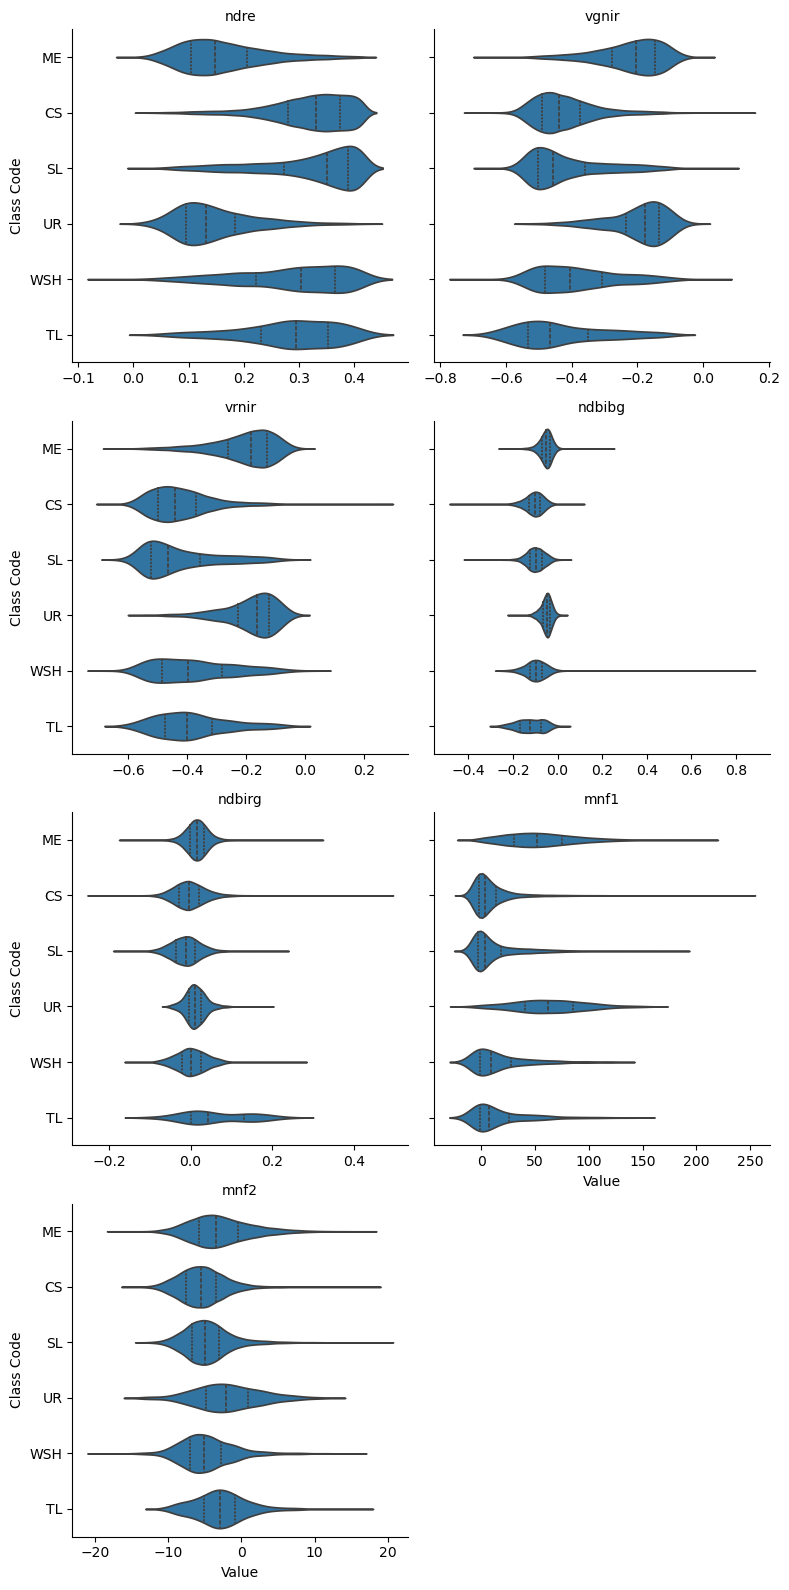

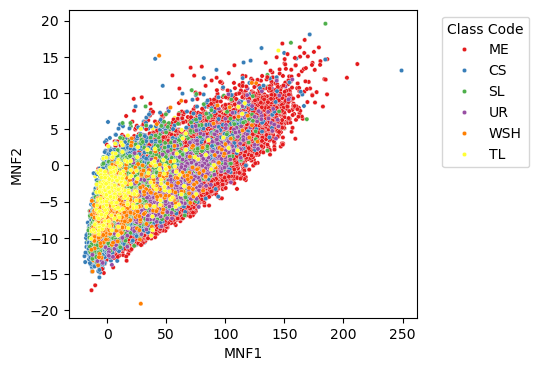

['ME' 'CS' 'SL' 'UR' 'WSH' 'TL']


In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#######################################
# Load the spectral library data      #
# Filter out likely vegetated samples #
#######################################

# Read in the sampled potential endmembers data frame
ref_sp = pd.read_csv("dc_data_reference_sampled_mnf.csv")
ref_sp = ref_sp[ref_sp['ndre'] < 0.42]  # filter out high NDRE values (vegetation)
# Select the needed columns
ref_sp = ref_sp[['class_code','ndre','vgnir','vrnir','ndbibg','ndbirg','mnf1','mnf2']]
ref_sp['class_code'] = ref_sp['class_code'].astype(str)
print(ref_sp.columns.values)

# Merge the Wood shingle (WS) and Shingle (SH) classes
merge = {'WS': 'WSH', 'SH': 'WSH'}
ref_sp['class_code'].replace(merge, inplace=True)
ref_sp['class_code'].value_counts()  # check the counts again
# Get a count of samples per class
ref_sp['class_code'].value_counts()

#########################################
# Plots and mean/median endmember array #
#########################################

# Create horizontal violin plot facet grid

# Melt the DataFrame to long format
ref_sp_m = ref_sp.melt(
    id_vars=['class_code'],
    value_vars=['ndre','vgnir','vrnir','ndbibg','ndbirg','mnf1','mnf2'],
    var_name='Band',
    value_name='Value')

# Create a facet plot
g = sns.catplot(data=ref_sp_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', col_wrap=2, height=4)

# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")
# Display the plot
plt.show()

# Create a scatter plot with MNF1 and MNF2, colored by class code
plt.figure(figsize=(4.5, 4))
sns.scatterplot(x='mnf1', y='mnf2', hue='class_code', data=ref_sp, palette='Set1', s=10)
plt.xlabel('MNF1')
plt.ylabel('MNF2')
plt.legend(title='Class Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Create an array of the class means
print(ref_sp['class_code'].unique())

class_codes = ref_sp['class_code'].unique()

Shape: (7, 7555, 6046); 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 7)>
array([1, 2, 3, 4, 5, 6, 7])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
    spatial_ref  int64 0; 
Band Names: ('ndre', 'vgnir', 'vrnir', 'ndbibg', 'ndbirg', 'mnf1', 'mnf2'); 
Data Type: float64


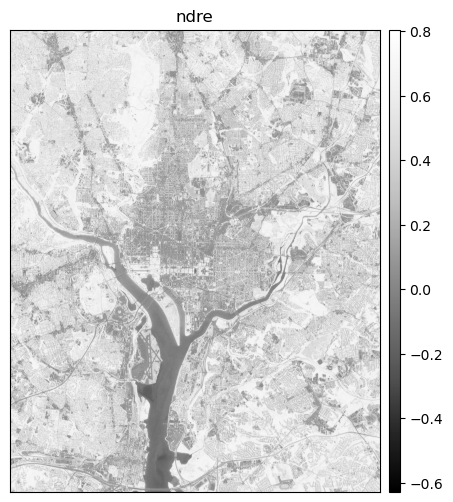

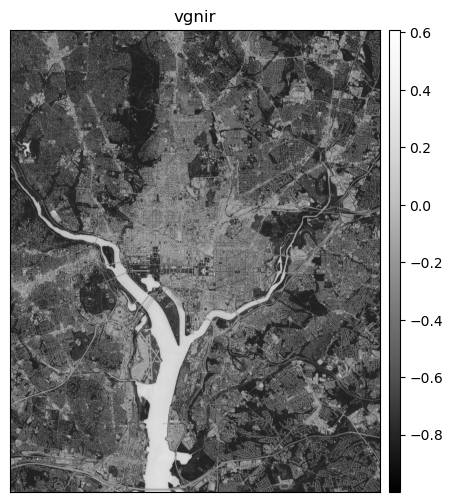

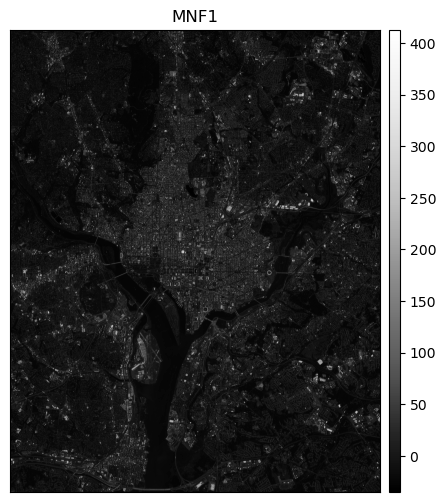

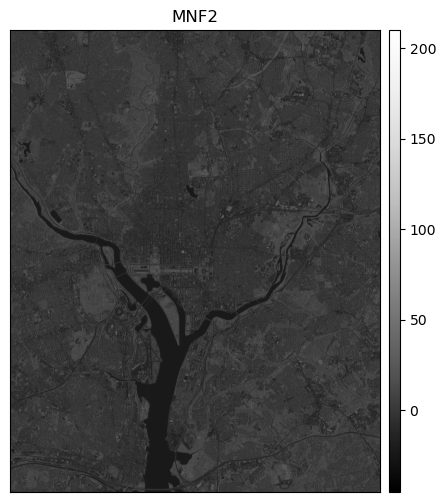

<Axes: title={'center': 'MNF2'}>

In [7]:
# Bring in the image file and get the projection information
mnf_path = "dc_data_psscene13b_mnf_ind.tif"
stack_mnf = rxr.open_rasterio(mnf_path)
print(
    f"Shape: {stack_mnf.shape}; \n"
    f"NoData Value: {stack_mnf.rio.nodata}; \n"
    f"Bands: {stack_mnf.band}; \n"
    f"Band Names: {stack_mnf.long_name}; \n"
    f"Data Type: {stack_mnf[0].dtype}")

# Plot one image as an example (green band)
ep.plot_bands(stack_mnf[0], title=["ndre"], figsize=(6,6))
ep.plot_bands(stack_mnf[1], title=["vgnir"], figsize=(6,6))
ep.plot_bands(stack_mnf[5], title=["MNF1"], figsize=(6,6))
ep.plot_bands(stack_mnf[6], title=["MNF2"], figsize=(6,6))

In [9]:
# Assuming the first column is 'roof_type', and the rest are the spectral bands
classes = ref_sp['class_code'].astype('category').cat.codes.values
print(ref_sp.columns.values)

# Attempt the PPI
class_codes = ref_sp['class_code'].unique()
class_ems_arrs = {}
class_ems_dfs = []
for cls in class_codes:
    print(f"Processing class: {cls} ...")
    df = ref_sp[ref_sp['class_code'] == cls]
    df_ = df.drop('class_code', axis=1)
    print(df_.columns.values)

    ems_df, ems_ind = _ppi_(df_.copy(), q=1, num_skewers=10000)
    print(ems_df)

    class_ems_arrs[cls] = ems_df.values

    ems_df.loc[:, 'class_code'] = cls
    class_ems_dfs.append(ems_df)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(class_ems_arrs['ME'])
print(class_ems_dfs[0])

# Merge the data frames
ems_df_out = pd.concat(class_ems_dfs)
print(ems_df_out)

['class_code' 'ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg' 'mnf1' 'mnf2']
Processing class: ME ...
['ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg' 'mnf1' 'mnf2']
           ndre     vgnir     vrnir    ndbibg    ndbirg       mnf1       mnf2
30679  0.023871 -0.026996 -0.024943 -0.047873  0.002055  211.76279  14.006434
Processing class: CS ...
['ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg' 'mnf1' 'mnf2']
           ndre     vgnir     vrnir    ndbibg    ndbirg       mnf1       mnf2
48913  0.023187  0.131695  0.268596 -0.090052  0.141921  249.19116  13.109599
Processing class: SL ...
['ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg' 'mnf1' 'mnf2']
           ndre     vgnir     vrnir    ndbibg    ndbirg       mnf1      mnf2
59160  0.043847 -0.051827 -0.036291 -0.083381  0.015565  184.75157  19.57431
Processing class: UR ...
['ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg' 'mnf1' 'mnf2']
           ndre     vgnir     vrnir    ndbibg    ndbirg       mnf1       mnf2
62719  0.062063 -0.097065 -0.094718 -0.057082  0.002369  1

In [13]:
for i in range(len(class_ems_arrs)):
    print(class_codes[i])
    em = class_ems_arrs[class_codes[i]].T
    print(f"Endmember array: \n{np.asarray(em)} \nShape: {em.shape} \nType: {type(em)}")
    
ems = np.array(class_ems_arrs).squeeze()
print(ems.shape)
print(ems)

ME
Endmember array: 
[[ 2.3870662e-02]
 [-2.6996090e-02]
 [-2.4942879e-02]
 [-4.7873434e-02]
 [ 2.0545935e-03]
 [ 2.1176279e+02]
 [ 1.4006434e+01]] 
Shape: (7, 1) 
Type: <class 'numpy.ndarray'>
CS
Endmember array: 
[[ 2.3187423e-02]
 [ 1.3169514e-01]
 [ 2.6859638e-01]
 [-9.0051780e-02]
 [ 1.4192140e-01]
 [ 2.4919116e+02]
 [ 1.3109599e+01]] 
Shape: (7, 1) 
Type: <class 'numpy.ndarray'>
SL
Endmember array: 
[[ 4.3846685e-02]
 [-5.1826846e-02]
 [-3.6290716e-02]
 [-8.3380600e-02]
 [ 1.5565406e-02]
 [ 1.8475157e+02]
 [ 1.9574310e+01]] 
Shape: (7, 1) 
Type: <class 'numpy.ndarray'>
UR
Endmember array: 
[[ 6.2062938e-02]
 [-9.7065460e-02]
 [-9.4717875e-02]
 [-5.7082452e-02]
 [ 2.3693726e-03]
 [ 1.5666165e+02]
 [ 1.1872742e+01]] 
Shape: (7, 1) 
Type: <class 'numpy.ndarray'>
WSH
Endmember array: 
[[ 7.8975840e-02]
 [-1.1614026e-01]
 [-1.0460251e-01]
 [-1.3112667e-01]
 [ 1.1679644e-02]
 [ 1.2613355e+02]
 [ 1.1366241e+01]] 
Shape: (7, 1) 
Type: <class 'numpy.ndarray'>
TL
Endmember array: 
[[ 8.156

In [14]:
# Grab projection information
# Get the WKT and GeoTransform
gdal.UseExceptions()  # Enable errors
try:
    ds = gdal.Open("dc_data_psscene13b_mnf_ind.tif")
    gt = ds.GetGeoTransform()
    wkt = ds.GetProjection()
except RuntimeError:  # <- Check first what exception is being thrown
    pass
del ds
print(f"GeoTransform: {gt}; \nWKT: {wkt}")

GeoTransform: (316269.0, 3.0, 0.0, 4318296.0, 0.0, -3.0); 
WKT: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [19]:
############################################
# Fully Constrained Least Squares Unmixing #
# Linear Spectral Mixture Analysis (LSMA)  #
# Single endmember per group               #
############################################

import time
import traceback
from tqdm.notebook import tqdm

ems = []
for cls, ems_ in class_ems_arrs.items():
    print(cls)
    ems.append(ems_)
ems = np.concatenate(ems)
print(ems)

stack_mnf_arr = np.asarray(stack_mnf)  # ensure that the MNF is a numpy array

num_processes = mp.cpu_count() - 1
print(f"Splitting across {num_processes} chunks for work ...")

# Check the data shapes
print(f"Image array (MNF) shape: {stack_mnf_arr.shape}; Endmember array shape: {ems.shape}")

# Split the MNF-transformed stack into chunks to be processed
chunks = np.array_split(stack_mnf_arr, num_processes, axis=2)
    
# Perform FCLS unmixing in parallel
start_time = time.time()
if __name__ == '__main__':
    
    # Function to parallelize FCLS unmixing
    def parallel_fcls_unmixing(chunk, endmembers):
        try:
            am = amap.FCLS()
            return am.map(chunk.T, endmembers, normalize=False)
        except Exception as e:
            traceback.print_exc()
            raise e
    
    with mp.Pool(processes=num_processes) as pool:
        try:
            unmix_results = pool.map(partial(parallel_fcls_unmixing, endmembers=ems), chunks)
            pool.close()
        except Exception as e:
            traceback.print_exc()
            raise e
        finally:
            pool.terminate()
            pool.join() 
            
print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.") 


ME
CS
SL
UR
WSH
TL
[[ 2.38706620e-02 -2.69960900e-02 -2.49428790e-02 -4.78734340e-02
   2.05459350e-03  2.11762790e+02  1.40064340e+01]
 [ 2.31874230e-02  1.31695140e-01  2.68596380e-01 -9.00517800e-02
   1.41921400e-01  2.49191160e+02  1.31095990e+01]
 [ 4.38466850e-02 -5.18268460e-02 -3.62907160e-02 -8.33806000e-02
   1.55654060e-02  1.84751570e+02  1.95743100e+01]
 [ 6.20629380e-02 -9.70654600e-02 -9.47178750e-02 -5.70824520e-02
   2.36937260e-03  1.56661650e+02  1.18727420e+01]
 [ 7.89758400e-02 -1.16140260e-01 -1.04602510e-01 -1.31126670e-01
   1.16796440e-02  1.26133550e+02  1.13662410e+01]
 [ 8.15696640e-02 -1.15887634e-01 -9.10708300e-02 -8.10735700e-02
   2.50815150e-02  1.44899500e+02  1.58728510e+01]]
Splitting across 31 chunks for work ...
Image array (MNF) shape: (7, 7555, 6046); Endmember array shape: (6, 7)
Time elapsed: 83.05666666666666 minutes.


In [20]:
# Retrieve the results
print(type(unmix_results))
print(len(unmix_results))

band_names = list(class_codes)
    
# Combine the FCLS results from all chunks back into a single array
ams_combined_parallel = np.concatenate(unmix_results)
print(f"Final combined array shape: {ams_combined_parallel.shape}")

<class 'list'>
31
Final combined array shape: (6046, 7555, 6)


In [21]:
print(gt, wkt)

(316269.0, 3.0, 0.0, 4318296.0, 0.0, -3.0) PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [23]:
# Export the abundance ndarray as a multiband raster
import xarray as xr

print(f"Original shape: {stack_mnf.shape}; \nAbundance maps shape: {ams_combined_parallel.shape}")
print(f"Length of 'y' attribute: {stack_mnf.y}; \nLength of shape[1]: {ams_combined_parallel.shape[1]}")

# Transpose the new array before exporting
in_arr = ams_combined_parallel.transpose(2, 1, 0)
print(in_arr.shape)

# Assign the correct coordinates for the transposed 'y' dimension
band_coords = range(in_arr.shape[0])
y_coords = stack_mnf.y.values
x_coords = stack_mnf.x.values

# Store the new array and export
out_arr = xr.DataArray(
    in_arr,
    dims=("band", "y", "x"),
    coords={
        "band": band_names,
        "y": y_coords,
        "x": x_coords,
    }
)

# Export the new DataArray as a new GeoTIFF file
# Assign projection information
out_arr.rio.set_crs(stack_mnf.rio.crs)  # Set the CRS
out_arr.rio.write_transform(stack_mnf.rio.transform())  # Set the GeoTransform

print(out_arr)

output_path = "fcls_abundance_maps.tif"
out_arr.rio.to_raster(output_path, compress='zstd', zstd_level=9,
                      dtype='float32', driver='GTiff')  # export to GeoTIFF
print("Success !! ...")

Original shape: (7, 7555, 6046); 
Abundance maps shape: (6046, 7555, 6)
Length of 'y' attribute: <xarray.DataArray 'y' (y: 7555)>
array([4318294.5, 4318291.5, 4318288.5, ..., 4295638.5, 4295635.5, 4295632.5])
Coordinates:
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0; 
Length of shape[1]: 7555
(6, 7555, 6046)
<xarray.DataArray (band: 6, y: 7555, x: 6046)>
array([[[4.66521755e-08, 3.27072733e-08, 3.17963824e-08, ...,
         4.50019257e-08, 4.37581953e-08, 3.27555938e-08],
        [3.12757500e-08, 2.54226666e-08, 2.51128505e-08, ...,
         4.37607390e-08, 5.48812018e-08, 3.71864708e-08],
        [2.48176342e-08, 2.42473703e-08, 2.40233717e-08, ...,
         4.24855848e-08, 4.88326215e-08, 3.42680302e-08],
        ...,
        [2.27153993e-08, 2.26107399e-08, 2.24274519e-08, ...,
         2.24435937e-08, 2.24439454e-08, 2.24651000e-08],
        [2.27196484e-08, 2.24501449e-08, 2.22021530e-08, ...,
         2.24809469e-08, 2.25164598

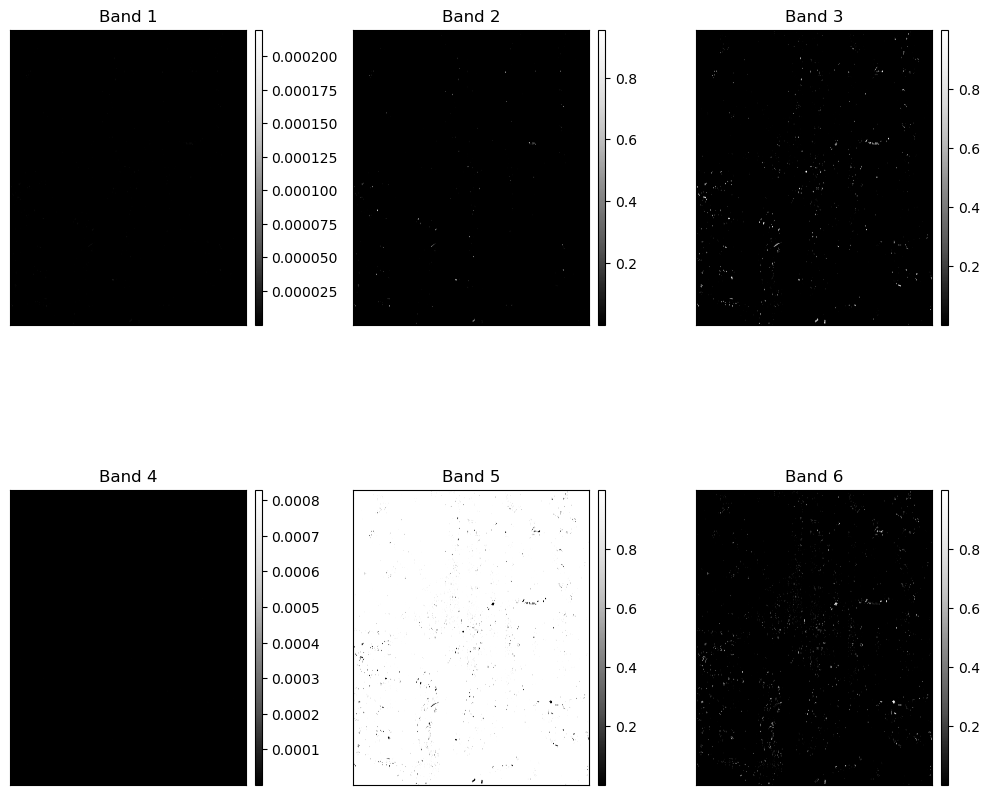

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>]], dtype=object)

In [24]:
ep.plot_bands(
    ams_combined_parallel.T,
    scale=False,
    figsize=(10,10))